In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to the files in your Google Drive
events_path = '/content/drive/My Drive/events_df_filtered.csv'
item_props_path = '/content/drive/My Drive/item_props_filtered.csv'
category_tree = '/content/drive/My Drive/data/TMP/category_tree.csv'

# Load the dataframes
try:
    category_tree = pd.read_csv(category_tree)
    events_df_filtered = pd.read_csv(events_path)
    item_props_filtered = pd.read_csv(item_props_path)
    print("Dataframes loaded successfully!")
except FileNotFoundError:
    print("Error: One or both files not found in your Google Drive.")
except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataframes loaded successfully!


In [ ]:
# Sample a percentage of the dataframes for performance testing
sample_percentage = 0.02  # Adjust as needed

item_props_sample = item_props_filtered.sample(frac=sample_percentage, random_state=42)
events_sample = events_df_filtered.sample(frac=sample_percentage, random_state=42)

print(f"\nShape of sampled item_props_filtered DataFrame ({sample_percentage*100}%):")
display(item_props_sample.shape)
print(f"\nShape of sampled events DataFrame ({sample_percentage*100}%):")
display(events_sample.shape)


Shape of sampled item_props_filtered DataFrame (2.0%):


(45837, 4)


Shape of sampled events DataFrame (2.0%):


(40530, 5)

In [ ]:
events_df_filtered.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-09-11 20:49:49.439,0,view,285930,0.0
1,2015-09-11 20:52:39.591,0,view,357564,0.0
2,2015-09-11 20:55:17.175,0,view,67045,0.0
3,2015-08-13 17:46:06.444,1,view,72028,0.0
4,2015-08-07 17:51:44.567,2,view,325215,0.0


In [ ]:
events_sample.head()

,timestamp,visitorid,event,itemid,transactionid
1533036,2015-06-28 02:54:52.549,1064245,view,300739,0.0
1077102,2015-08-07 19:55:40.821,748438,view,378290,0.0
521129,2015-08-02 21:51:08.448,362099,view,289103,0.0
180729,2015-08-02 18:41:36.932,125869,view,115263,0.0
1468918,2015-06-13 01:05:10.415,1020220,view,112537,0.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Build item profiles from properties
item_features = item_props_sample.groupby("itemid")["value"].apply(lambda x: " ".join(x.astype(str))).reset_index()

# TF-IDF on item features
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(item_features["value"])

# Cosine similarity between items
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Map item_id to index
indices = pd.Series(item_features.index, index=item_features["itemid"])

# Function: Recommend items similar to a given item
def recommend_content(itemid, top_n=5):
    if itemid not in indices:
        return f"Item {itemid} not found."
    idx = indices[itemid]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    item_indices = [i[0] for i in sim_scores]
    return item_features.iloc[item_indices]["itemid"].tolist()

# Example
print("CBF Recommendations for item 405090:", recommend_content(itemid=405090, top_n=5))

CBF Recommendations for item 405090: [157081, 281541, 293048, 293482, 349991]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assign weights to implicit events
weight_map = {"view": 1, "addtocart": 3, "transaction": 5}
events_df_filtered["weight"] = events_sample["event"].map(weight_map)

# Build Visitor-Item Matrix
user_item_matrix = events_df_filtered.pivot_table(
    index="visitorid", columns="itemid", values="weight", fill_value=0
)

# Compute user-user similarity
user_similarity = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Function: Recommend items for a visitor
def recommend_cf(visitorid, top_n=5):
    if visitorid not in user_item_matrix.index:
        return f"Visitor {visitorid} not found."

    # Find most similar users
    similar_users = user_sim_df[visitorid].sort_values(ascending=False).index[1:]

    # Get items from similar users
    recommendations = events_df_filtered[events_df_filtered["visitorid"].isin(similar_users)] \
                        .groupby("itemid")["weight"].sum().sort_values(ascending=False)

    # Remove items the visitor already interacted with
    seen_items = set(events_df_filtered[events_df_filtered["visitorid"] == visitorid]["itemid"])
    recommendations = recommendations[~recommendations.index.isin(seen_items)]

    return recommendations.head(top_n).index.tolist()

# Example
print("CF Recommendations for visitor 748438:", recommend_cf(visitorid=748438, top_n=5))

CF Recommendations for visitor 748438: [187946, 5411, 298009, 257040, 96924]


In [ ]:
def hybrid_recommend(visitorid, itemid, alpha=0.6, top_n=5):
    cf_recs = recommend_cf(visitorid, top_n*2)
    cb_recs = recommend_content(itemid, top_n*2)

    # Simple scoring: CF stronger
    scores = {}
    for i, it in enumerate(cf_recs):
        scores[it] = scores.get(it, 0) + alpha*(1/(i+1))
    for i, it in enumerate(cb_recs):
        scores[it] = scores.get(it, 0) + (1-alpha)*(1/(i+1))

    return sorted(scores, key=scores.get, reverse=True)[:top_n]

# Example
print("Hybrid Recommendations for visitorid=748438 and itemid=405090:", hybrid_recommend(visitorid=748438, itemid=405090, top_n=5))

Hybrid Recommendations for visitorid=748438 and itemid=405090: [187946, 157081, 5411, 281541, 298009]


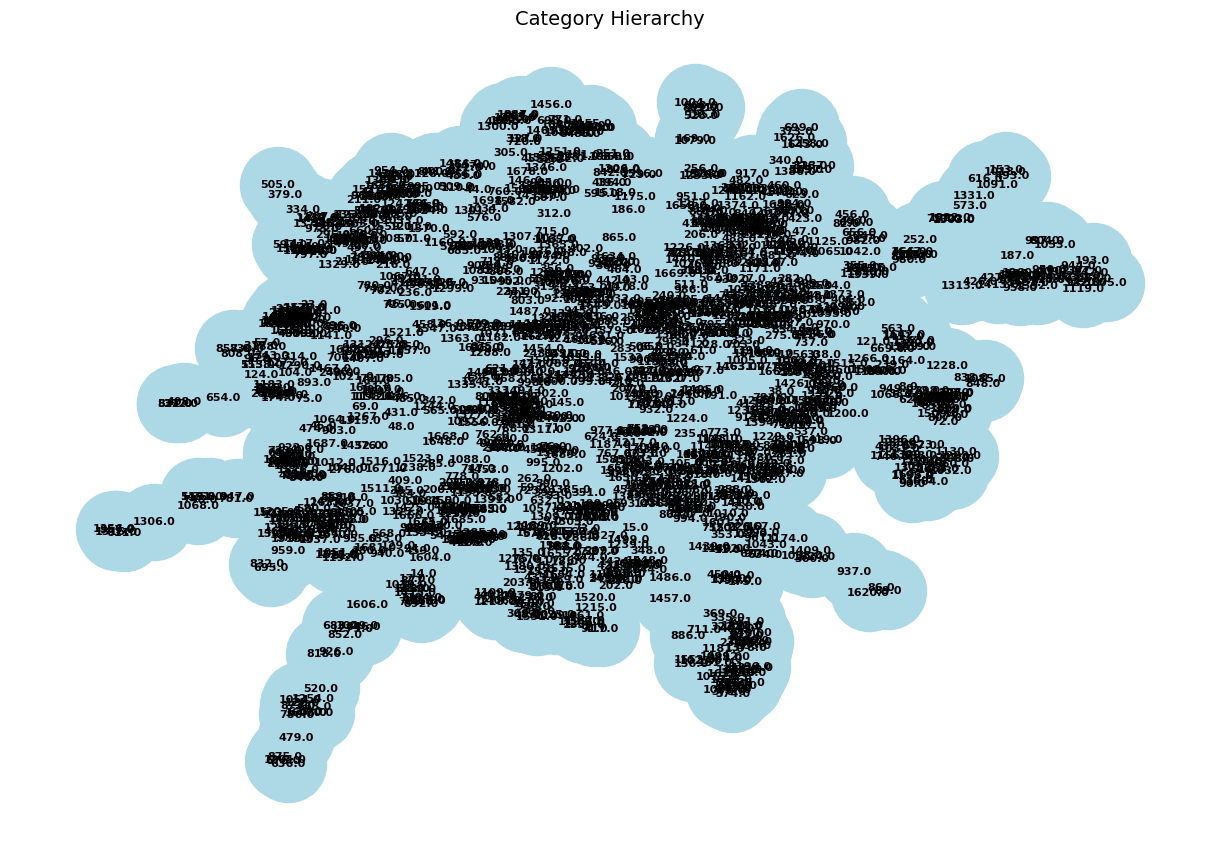

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph from category_tree
G = nx.DiGraph()
for _, row in category_tree.iterrows():
    if pd.notna(row["parentid"]):
        G.add_edge(row["parentid"], row["categoryid"])

# Plot category hierarchy
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, font_weight="bold", arrows=True)
plt.title("Category Hierarchy", fontsize=14)
plt.show()

In [ ]:
# Map items to categories
item_category_map = item_props_filtered[item_props_filtered["property"] == "categoryid"].set_index("itemid")["value"].to_dict()

def recommend_by_category(itemid, top_n=5):
    if itemid not in item_category_map:
        return f"Item {itemid} has no category."

    category = item_category_map[itemid]

    # Find items in same category
    same_category_items = [k for k, v in item_category_map.items() if v == category and k != itemid]

    return same_category_items[:top_n]

# Example
print("Category-based Recommendations for item 187946:", recommend_by_category(itemid=187946, top_n=5))

Category-based Recommendations for item 187946: [444663, 177065, 106968, 350580, 78682]


In [ ]:
def hybrid_category(visitorid, itemid, alpha=0.6, top_n=5):
    hybrid_recs = hybrid_recommend(visitorid, itemid, alpha, top_n*3)

    # Restrict to same category as the target item
    if itemid in item_category_map:
        target_cat = item_category_map[itemid]
        hybrid_recs = [it for it in hybrid_recs if item_category_map.get(it) == target_cat]

    return hybrid_recs[:top_n]

# Example
print("Hybrid + Category Recommendations:", hybrid_category(visitorid=414122, itemid=405090, top_n=5))

Hybrid + Category Recommendations: [157081, 281541, 293048, 293482, 349991]


## User segment tailoring

### Subtask:
Customize the product page layout and content based on the identified user segments.


**Reasoning**:
Access the cluster label for a given visitorid and describe how the product page would be customized for each cluster.



In [ ]:
# Sort events by visitorid and timestamp
events_sample = events_sample.sort_values(by=['visitorid', 'timestamp'])

# Convert 'timestamp' to datetime objects
events_sample['timestamp'] = pd.to_datetime(events_sample['timestamp'])

# Calculate time difference between consecutive events for each visitor in the sampled data
events_sample['time_diff'] = events_sample.groupby('visitorid')['timestamp'].diff().dt.total_seconds().fillna(0)

# Create features for each visitor using the sampled data
user_features = events_sample.groupby('visitorid').agg(
    num_events=('event', 'count'),
    unique_events=('event', lambda x: x.nunique()),
    time_spent=('time_diff', 'sum'),
    avg_time_between_events=('time_diff', 'mean'),
    max_time_between_events=('time_diff', 'max'),
    num_items_viewed=('itemid', lambda x: x[events_sample.loc[x.index, 'event'] == 'view'].nunique()),
    num_adds_to_cart=('itemid', lambda x: x[events_sample.loc[x.index, 'event'] == 'addtocart'].nunique()),
    num_transactions=('itemid', lambda x: x[events_sample.loc[x.index, 'event'] == 'transaction'].nunique())
).reset_index()

# Display the first few rows and info of the user features DataFrame
print("First few rows of user_features:")
display(user_features.head())
print("\nInfo for user_features DataFrame:")
user_features.info()

First few rows of user_features:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions
0,16,1,1,0.0,0.0,0.0,1,0,0
1,36,1,1,0.0,0.0,0.0,1,0,0
2,46,1,1,0.0,0.0,0.0,1,0,0
3,95,1,1,0.0,0.0,0.0,1,0,0
4,224,1,1,0.0,0.0,0.0,1,0,0



Info for user_features DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39940 entries, 0 to 39939
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   visitorid                39940 non-null  int64  
 1   num_events               39940 non-null  int64  
 2   unique_events            39940 non-null  int64  
 3   time_spent               39940 non-null  float64
 4   avg_time_between_events  39940 non-null  float64
 5   max_time_between_events  39940 non-null  float64
 6   num_items_viewed         39940 non-null  int64  
 7   num_adds_to_cart         39940 non-null  int64  
 8   num_transactions         39940 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 2.7 MB


### Perform User Clustering

**Reasoning**: To create the `cluster_label` column needed for tailoring the product page, we will perform K-Means clustering on the `user_features` DataFrame. Before clustering, the features will be scaled to ensure that no single feature dominates the clustering process due to its magnitude.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering (excluding visitorid as it's an identifier)
features_for_clustering = user_features.drop('visitorid', axis=1)

# Scale the features
scaler = StandardScaler()
scaled_user_features = scaler.fit_transform(features_for_clustering)

# Determine the optimal number of clusters (e.g., using the elbow method or silhouette score)
# For demonstration purposes, let's choose a fixed number of clusters, say 3.
# In a real-world scenario, you would analyze to find the best number of clusters.
n_clusters = 3

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init for KMeans
user_features['cluster_label'] = kmeans.fit_predict(scaled_user_features)

# Display the first few rows of user features with the new cluster label
print("User features with cluster labels:")
display(user_features.head())

# Display the distribution of users across clusters
print("\nDistribution of users across clusters:")
display(user_features['cluster_label'].value_counts())

User features with cluster labels:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,cluster_label
0,16,1,1,0.0,0.0,0.0,1,0,0,0
1,36,1,1,0.0,0.0,0.0,1,0,0,0
2,46,1,1,0.0,0.0,0.0,1,0,0,0
3,95,1,1,0.0,0.0,0.0,1,0,0,0
4,224,1,1,0.0,0.0,0.0,1,0,0,0



Distribution of users across clusters:


,count
cluster_label,
0,39612
2,312
1,16


In [ ]:
def customize_product_page(visitorid, user_features):
    """
    Determines product page customization based on user segment.

    Args:
        visitorid: The ID of the visitor.
        user_features: DataFrame containing user features including cluster_label.

    Returns:
        A dictionary describing the product page customization for the user's segment.
    """
    user_segment_info = user_features[user_features['visitorid'] == visitorid]

    if user_segment_info.empty:
        # Default customization for unknown users
        return {
            'segment': 'Unknown',
            'description': 'Standard product page layout and content.',
            'customization_examples': [
                'Show basic product information.',
                'Include general popular items in recommendations.',
                'Standard call to action buttons.'
            ]
        }
    else:
        cluster_label = user_segment_info['cluster_label'].iloc[0]

        if cluster_label == 0:
            return {
                'segment': 'Less Engaged Users (Cluster 0)',
                'description': 'Tailored for users with low interaction counts.',
                'customization_examples': [
                    'Emphasize product benefits and value proposition.',
                    'Highlight popular and easy-to-understand product features.',
                    'Show recommendations for best-selling or introductory items.',
                    'Clear and prominent call to action buttons (e.g., "Add to Cart").',
                    'Simplify page layout to avoid overwhelming the user.'
                ]
            }
        elif cluster_label == 1:
            return {
                'segment': 'Highly Engaged Users (Cluster 1)',
                'description': 'Tailored for users with high interaction and purchase frequency.',
                'customization_examples': [
                    'Provide detailed product specifications and technical information.',
                    'Show recommendations for complementary products or premium items.',
                    'Include user reviews and testimonials prominently.',
                    'Offer personalized deals or loyalty program information.',
                    'Faster checkout options or saved payment methods display.'
                ]
            }
        elif cluster_label == 2:
            return {
                'segment': 'Moderately Engaged Users (Cluster 2)',
                'description': 'Tailored for users with moderate interaction levels.',
                'customization_examples': [
                    'Balance detailed information with clear visuals.',
                    'Show a mix of popular items and items similar to their viewing history in recommendations.',
                    'Include social proof like "X users also viewed this".',
                    'Offer options to compare products.',
                    'Promote signing up for newsletters or creating an account.'
                ]
            }
        else:
            # Fallback for any other unexpected cluster labels
            return {
                'segment': f'Unexpected Cluster ({cluster_label})',
                'description': 'Standard product page layout and content.',
                'customization_examples': [
                    'Show basic product information.',
                    'Include general popular items in recommendations.',
                    'Standard call to action buttons.'
                ]
            }

# Example usage:
# Assuming visitor 748438 belongs to a segment (check user_features)
example_visitorid_segment = 748438 # Replace with a visitorid present in user_features

customization_info = customize_product_page(example_visitorid_segment, user_features)

print(f"Product Page Customization for Visitor {example_visitorid_segment}:")
display(customization_info)

# Example for a visitor not in user_features (assuming visitorid 999999 is not in the sample)
example_visitorid_unknown = 999999
unknown_customization_info = customize_product_page(example_visitorid_unknown, user_features)

print(f"\nProduct Page Customization for Unknown Visitor {example_visitorid_unknown}:")
display(unknown_customization_info)

Product Page Customization for Visitor 748438:


{'segment': 'Less Engaged Users (Cluster 0)',
 'description': 'Tailored for users with low interaction counts.',
 'customization_examples': ['Emphasize product benefits and value proposition.',
  'Highlight popular and easy-to-understand product features.',
  'Show recommendations for best-selling or introductory items.',
  'Clear and prominent call to action buttons (e.g., "Add to Cart").',
  'Simplify page layout to avoid overwhelming the user.']}


Product Page Customization for Unknown Visitor 999999:


{'segment': 'Unknown',
 'description': 'Standard product page layout and content.',
 'customization_examples': ['Show basic product information.',
  'Include general popular items in recommendations.',
  'Standard call to action buttons.']}

## Integrate anomaly detection

### Subtask:
Potentially use the abnormal user detection to tailor the experience for suspected bots or fraudulent users, perhaps by showing different product recommendations or security checks.


**Reasoning**:
Implement a function to tailor the user experience based on whether they are classified as abnormal or normal, then demonstrate its usage with example visitor IDs.



### Perform Anomaly Detection

**Reasoning**: To identify potential abnormal users, we will apply an Isolation Forest model to the scaled user features. The Isolation Forest is an unsupervised learning algorithm that works well for anomaly detection by isolating outliers.

In [ ]:
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection (same as clustering features)
features_for_anomaly_detection = user_features.drop(['visitorid', 'cluster_label'], axis=1) # Exclude visitorid and cluster_label

# Scale the features (using the same scaler fitted for clustering)
# If you were doing anomaly detection independently, you would fit a new scaler
scaled_user_features_ad = scaler.transform(features_for_anomaly_detection)

# Initialize and train the Isolation Forest model
# contamination='auto' lets the model decide the proportion of outliers
isolation_forest = IsolationForest(contamination='auto', random_state=42)
user_features['anomaly_label'] = isolation_forest.fit_predict(scaled_user_features_ad)

# The Isolation Forest predicts -1 for outliers (anomalies) and 1 for inliers (normal)
# Create a DataFrame of abnormal users
abnormal_users = user_features[user_features['anomaly_label'] == -1].copy()

# Create a DataFrame of normal users for example usage
normal_users = user_features[user_features['anomaly_label'] == 1].copy()


print("First few rows of user features with anomaly labels:")
display(user_features.head())

print("\nNumber of users classified as abnormal:")
display(abnormal_users.shape[0])

print("\nNumber of users classified as normal:")
display(normal_users.shape[0])

First few rows of user features with anomaly labels:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,cluster_label,anomaly_label
0,16,1,1,0.0,0.0,0.0,1,0,0,0,1
1,36,1,1,0.0,0.0,0.0,1,0,0,0,1
2,46,1,1,0.0,0.0,0.0,1,0,0,0,1
3,95,1,1,0.0,0.0,0.0,1,0,0,0,1
4,224,1,1,0.0,0.0,0.0,1,0,0,0,1



Number of users classified as abnormal:


927


Number of users classified as normal:


39013

In [ ]:
def tailor_experience_for_user(visitorid, user_features, abnormal_users):
    """
    Tailors the user experience based on whether the visitor is classified as abnormal.

    Args:
        visitorid: The ID of the visitor.
        user_features: DataFrame containing user features and anomaly_label.
        abnormal_users: DataFrame containing users classified as abnormal.

    Returns:
        A dictionary describing the tailored experience.
    """
    if visitorid in abnormal_users['visitorid'].values:
        # User is abnormal
        return {
            'user_type': 'Abnormal User',
            'tailoring': 'Apply security measures or show alternative content.',
            'examples': [
                'Display security verification step.',
                'Limit access to certain features.',
                'Show a curated list of highly trusted items.',
                'Reduce or hide personalized recommendations.'
            ]
        }
    elif visitorid in user_features['visitorid'].values:
         # User is normal (present in user_features but not in abnormal_users)
         return {
             'user_type': 'Normal User',
             'tailoring': 'Proceed with standard or personalized experience.',
             'examples': [
                 'Show personalized recommendations based on viewing history and segment.',
                 'Display full product page content.',
                 'Allow standard checkout process.'
             ]
         }
    else:
        # User is not in the sampled data (treated as normal for this function's scope)
        # In a real system, you might have a different default or attempt to load their data
        return {
            'user_type': 'Unknown User (Treated as Normal)',
            'tailoring': 'Proceed with standard experience.',
            'examples': [
                'Show popular items and general content.',
                'Standard product page layout.'
            ]
        }

# Example usage:
# Example visitorid known to be abnormal (take one from the abnormal_users DataFrame)
example_abnormal_visitorid = abnormal_users['visitorid'].iloc[0]
abnormal_user_experience = tailor_experience_for_user(example_abnormal_visitorid, user_features, abnormal_users)
print(f"Experience for Abnormal User {example_abnormal_visitorid}:")
display(abnormal_user_experience)

# Example visitorid known to be normal (take one from the normal_users DataFrame)
example_normal_visitorid = normal_users['visitorid'].iloc[0]
normal_user_experience = tailor_experience_for_user(example_normal_visitorid, user_features, abnormal_users)
print(f"\nExperience for Normal User {example_normal_visitorid}:")
display(normal_user_experience)

# Example visitorid not in the sampled data
example_unknown_visitorid = 9999999 # Assuming this ID is not in user_features
unknown_user_experience = tailor_experience_for_user(example_unknown_visitorid, user_features, abnormal_users)
print(f"\nExperience for Unknown User {example_unknown_visitorid}:")
display(unknown_user_experience)

Experience for Abnormal User 918:


{'user_type': 'Abnormal User',
 'tailoring': 'Apply security measures or show alternative content.',
 'examples': ['Display security verification step.',
  'Limit access to certain features.',
  'Show a curated list of highly trusted items.',
  'Reduce or hide personalized recommendations.']}


Experience for Normal User 16:


{'user_type': 'Normal User',
 'tailoring': 'Proceed with standard or personalized experience.',
 'examples': ['Show personalized recommendations based on viewing history and segment.',
  'Display full product page content.',
  'Allow standard checkout process.']}


Experience for Unknown User 9999999:


{'user_type': 'Unknown User (Treated as Normal)',
 'tailoring': 'Proceed with standard experience.',
 'examples': ['Show popular items and general content.',
  'Standard product page layout.']}

In [ ]:
# Define the paths to save the new dataframes in your Google Drive
user_features_save_path = '/content/drive/My Drive/user_features.csv'
abnormal_users_save_path = '/content/drive/My Drive/abnormal_users.csv'
normal_users_save_path = '/content/drive/My Drive/normal_users.csv'

# Save the dataframes to CSV
try:
    user_features.to_csv(user_features_save_path, index=False)
    abnormal_users.to_csv(abnormal_users_save_path, index=False)
    normal_users.to_csv(normal_users_save_path, index=False)
    print("Newly created dataframes saved successfully to Google Drive!")
except Exception as e:
    print(f"An error occurred while saving dataframes: {e}")

Newly created dataframes saved successfully to Google Drive!
